In [36]:
# Import Libraries 
# ----------------------------------------------
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [37]:
# Parameter Configuration 
# -----------------------
nx   = 201          # number of grid points in x-direction
nz   = nx           # number of grid points in z-direction
# Note: regular 2D grid, dz = dx
dx   = 1.           # grid point distance in x-direction
dz   = dx           # grid point distance in z-direction
c0   = 500.         # wave velocity in medium (m/s)
isx  = 100          # source location in grid in x-direction
isz  = isx          # source location in grid in z-direction
nt   = 402          # maximum number of time steps
dt   = 0.0010       # time step
f0   = 100. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift
idisp = 5 # display frequency

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "slab"

# Receiver locations
irx = np.array([ 80, 90, 100, 110, 120])
irz = np.array([25, 25, 25, 25, 25])
seis = np.zeros((len(irx), nt))

print('Source frequency =', f0, 'Hz')

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx # epsilon value
print('Stability criterion =', eps)

# Initialize pressure at different time steps and the second
# derivatives in each direction
## -------------------------
p    = np.zeros((nz, nx, nt)) # p at time n (now)
d2px = np.zeros((nz, nx))#, nt)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx))#, nt)) # 2nd space derivative of p in z-direction


Source frequency = 100.0 Hz
Stability criterion = 0.5


In [38]:
# Initialize velocity model (the fun bit!)
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "fault_zone":
    c += c0
    c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8    
elif model_type == "surface_low_velocity_zone":
    c += c0
    c[1:10,:] *= 0.8
elif model_type == "random":
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    c += c0 * (1 + r)   
elif model_type == "topography":
    c += c0
    c[0 : 10, 10 : 50] = 0                         
    c[0 : 10, 105 : 115] = 0                       
    c[0 : 30, 145 : 170] = 0
    c[10 : 40, 20 : 40]  = 0
    c[0 : 15, 50 : 105] *= 0.8    
elif model_type == "slab":
    c += c0
    c[110 : 125, 0 : 125] = 1.4 * c0
    for i in range(110, 180):
        c[i , i-5 : i + 15 ] = 1.4 * c0
else:
    raise NotImplementedError
    
cmax = c.max()

In [39]:
# Initialize Velocity Model (assume homogeneous model)
# ----------------------------------------------------
#c    = np.zeros((nz, nx))
#c    = c + c0             # initialize wave velocity in model

# Initialize Grid
x    = np.arange(nx)
x    = x * dx             # coordinate in x-direction
z    = np.arange(nz)
z    = z * dz             # coordinate in z-direction

# Initialize Source Time Function 
# -------------------------
# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

<IPython.core.display.Javascript object>


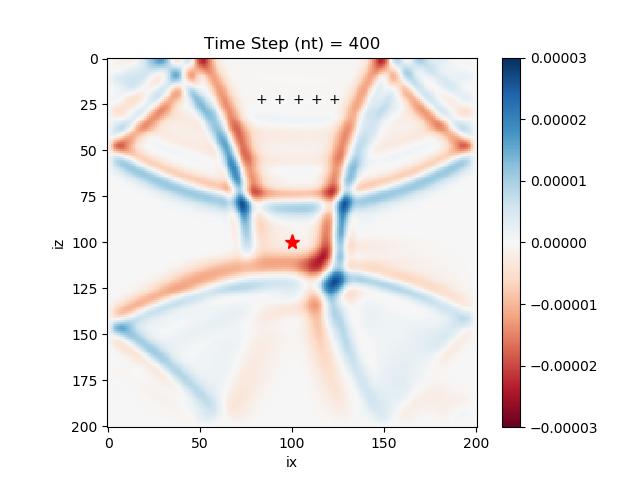

In [40]:
# Plot preparation

v = max([np.abs(src.min()), np.abs(src.max())])
# Initialize animated plot
pnew=p[:,:,0]
image = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-0.00003, vmax=0.00003, cmap=plt.cm.RdBu)

# Plot the receivers
for x, z in zip(irx, irz):
    plt.text(x, z, '+')

plt.plot(isx, isz, 'r*', markersize=11)
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')


plt.ion()
#plt.show(block=False)

# required for seismograms
ir = np.arange(len(irx))

In [41]:
# 2D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
# Time extrapolation
for it in range(nt-1):
    for i in range(1, nx - 1):
        d2pz[i, :] = (p[i - 1, :,it] - 2 * p[i, :,it] + p[i + 1, :,it]) / dz ** 2 
    for j in range(1, nz - 1):
        d2px[:, j] = (p[:, j - 1,it] - 2 * p[:, j,it] + p[:, j + 1,it]) / dx ** 2

    # Time Extrapolation
    # ------------------
    p[:,:,it+1] = 2 * p[:,:,it] - p[:,:,it-1] + (c ** 2) * (dt ** 2) * (d2pz + d2px)
    
    # Add Source Term at isz and isx
    # ------------------------------
    # Absolute pressure w.r.t analytical solution
    p[isz, isx,it+1] = p[isz, isx,it+1] + src[it] / (dx * dz) * (dt ** 2)
    pnew=p[:,:,it]
    
    # Set Boundary Conditions comment / uncomment
#    p[0,:,it+1] = 0                       # Fixed end
    p[nz-1,:,it+1] = 0                    # Fixed end
    p[:,0,it+1] = 0                       # Fixed end
    p[:,nx-1,it+1] = 0                    # Fixed end
#    p[nz-1,:, it+1] = p[nz-2,:, it+1]      # Free end
    p[0,:, it + 1] = p[1,:, it + 1]        # Free end
#    p[:,nx-1, it+1] = p[:,nx-2, it+1]      # Free end
#    p[:,0, it + 1] = p[:,1, it + 1]        # Free end    
#    p[nx-1,:, it + 1] = p[nx - 2,:, it]      # ABC
#    p[0,:, it + 1] = p[1,:, it]              # ABC
#    p[:,nz-1, it + 1] = p[:,nz - 2, it]      # ABC
#    p[:,0, it + 1] = p[:,1, it]              # ABC 
    
    # Plot every time step (nt)
    if (it % idisp) == 0:
        plt.title('Time Step (nt) = %d' % it)    
        image.set_data(pnew)
        plt.gcf().canvas.draw()

    # Save seismograms
    seis[ir, it] = p[irz[ir], irx[ir],it]

<IPython.core.display.Javascript object>


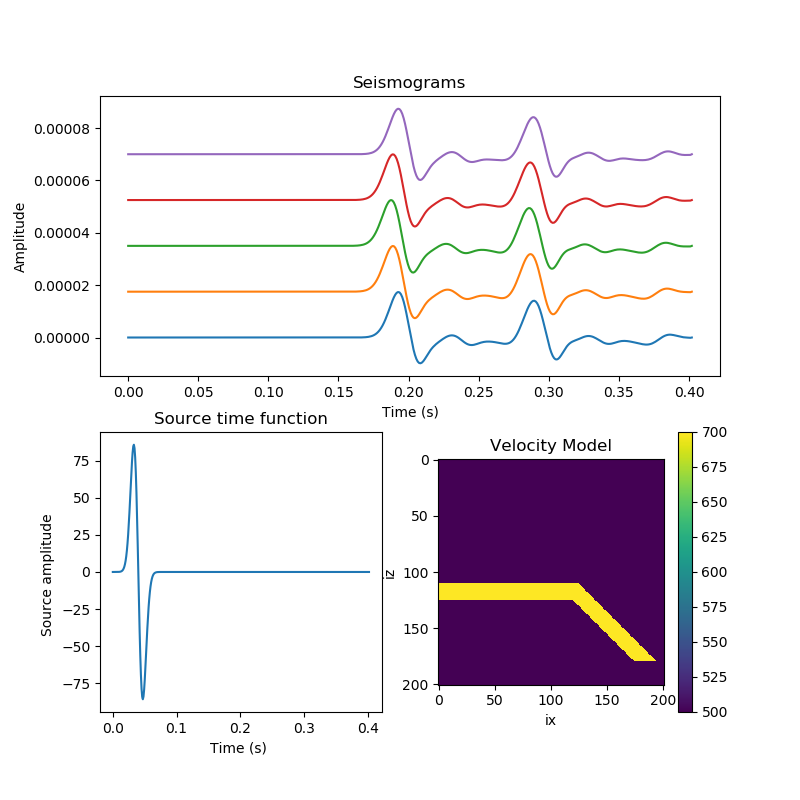

In [42]:
# Plot the source time function and the seismograms 

plt.ion()
fig = plt.figure(figsize=(8, 8))

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
plt.title('Seismograms')
ymax = seis.ravel().max()
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

ax2 = fig.add_subplot(gs[-1, 0])
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')
#plt.xlim(time.min(),time.max())
#plt.ylim(src.min(),src.max())

ax3 = fig.add_subplot(gs[-1, -1])
plt.title('Velocity Model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()

plt.show()